In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# --- 1. 모델 클래스 정의 ---
# (ResBlock, EncoderSuperDeep, DecoderSuperDeep, InterpolationNet, InterpolationDataset 클래스)
# (이전 코드와 동일하므로 여기에 다시 붙여넣으시면 됩니다.)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels), nn.SiLU(), nn.Conv2d(out_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels))
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.silu = nn.SiLU()
    def forward(self, x): return self.silu(self.block(x) + self.shortcut(x))

class EncoderSuperDeep(nn.Module):
    def __init__(self, in_channels=3, base_channels=128, latent_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(in_channels, base_channels, 3, 1, 1), ResBlock(base_channels, base_channels), nn.Conv2d(base_channels, base_channels*2, 3, 2, 1), ResBlock(base_channels*2, base_channels*2), nn.Conv2d(base_channels*2, base_channels*4, 3, 2, 1), ResBlock(base_channels*4, base_channels*4), nn.Conv2d(base_channels*4, base_channels*8, 3, 2, 1), ResBlock(base_channels*8, base_channels*8), nn.Conv2d(base_channels*8, base_channels*16, 3, 2, 1), ResBlock(base_channels*16, base_channels*16), nn.Conv2d(base_channels*16, 2 * latent_channels, 3, 1, 1))
    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=1)
        return mu, log_var

class DecoderSuperDeep(nn.Module):
    def __init__(self, out_channels=3, base_channels=128, latent_channels=1):
        super().__init__()
        self.decoder = nn.Sequential(nn.Conv2d(latent_channels, base_channels*16, 3, 1, 1), ResBlock(base_channels*16, base_channels*16), nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*16, base_channels*8, 3, 1, 1), ResBlock(base_channels*8, base_channels*8), nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*8, base_channels*4, 3, 1, 1), ResBlock(base_channels*4, base_channels*4), nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*4, base_channels*2, 3, 1, 1), ResBlock(base_channels*2, base_channels*2), nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*2, base_channels, 3, 1, 1), ResBlock(base_channels, base_channels), nn.Conv2d(base_channels, out_channels, 3, 1, 1), nn.Tanh())
    def forward(self, z): return self.decoder(z)

class InterpolationNet(nn.Module):
    def __init__(self, latent_dim=256, hidden_dim=1024):
        super().__init__()
        input_dim = latent_dim * 2 + 1
        self.network = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2, inplace=True), nn.Linear(hidden_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2, inplace=True), nn.Linear(hidden_dim, hidden_dim // 2), nn.BatchNorm1d(hidden_dim // 2), nn.LeakyReLU(0.2, inplace=True), nn.Linear(hidden_dim // 2, latent_dim))
    def forward(self, z_a, z_b, alpha):
        net_input = torch.cat([z_a, z_b, alpha], dim=1)
        return self.network(net_input)

class InterpolationDataset(Dataset):
    def __init__(self, latent_vectors_path, num_samples):
        self.latent_vectors = torch.load(latent_vectors_path).to('cpu')
        self.num_latents = len(self.latent_vectors)
        self.num_samples = num_samples
    def __len__(self):
        return self.num_samples
    def __getitem__(self, idx):
        idx1, idx2 = torch.randperm(self.num_latents)[:2]
        z_a = self.latent_vectors[idx1]
        z_b = self.latent_vectors[idx2]
        alpha = torch.rand(1)
        return z_a, z_b, alpha

# --- 2. 기본 설정 및 경로 ---
print("Step 1: 기본 설정 로드")
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
AE_CHECKPOINT_DIR = '/home/nas/data/YMG/superdeep_ae/checkpoints/'
ENCODER_PATH = os.path.join(AE_CHECKPOINT_DIR, 'encoder_superdeep_best.pth')
DECODER_PATH = os.path.join(AE_CHECKPOINT_DIR, 'decoder_superdeep_best.pth')
LATENT_VECTORS_PATH = '/home/nas/data/YMG/superdeep_ae/my_checkpoints/real_latent_vectors_20k.pt'
OUTPUT_DIR = '/home/nas/data/YMG/superdeep_ae/light_interpolation_network_attraction/'
os.makedirs(OUTPUT_DIR, exist_ok=True)
CHECKPOINT_PATH = os.path.join(OUTPUT_DIR, 'interpolation_net_best.pth')


# --- 하이퍼파라미터 ---
LATENT_DIM = 256
HIDDEN_DIM = 1024
BATCH_SIZE = 256
EPOCHS = 10
LR = 1e-3 # 이전보다 10배 높여서 설정
SAMPLES_PER_EPOCH = 30000
ATTRACTION_WEIGHT = 0.1 # <<< 추가: 매력 항의 가중치 (lambda) >>>


# --- 3. 모델 로드 및 설정 ---
print("Step 2: 모델 로드 및 설정")
encoder = EncoderSuperDeep(base_channels=128).to(DEVICE); encoder.eval()
decoder = DecoderSuperDeep(base_channels=128).to(DEVICE); decoder.eval()
for param in encoder.parameters(): param.requires_grad = False
for param in decoder.parameters(): param.requires_grad = False
print("VAE 모델을 로드하고 가중치를 동결했습니다.")

interpolation_net = InterpolationNet(latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM).to(DEVICE)
optimizer = optim.Adam(interpolation_net.parameters(), lr=LR)
print("보간 네트워크를 초기화했습니다.")


# --- 4. 데이터 로더 준비 ---
print("Step 3: 데이터 로더 준비")
train_dataset = InterpolationDataset(latent_vectors_path=LATENT_VECTORS_PATH, num_samples=SAMPLES_PER_EPOCH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


# --- 5. 학습 루프 (손실 함수 수정됨) ---
print("Step 4: 학습 시작")
best_loss = float('inf')
for epoch in range(EPOCHS):
    interpolation_net.train()
    total_loss, total_reproj_loss, total_attr_loss = 0, 0, 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for z_a, z_b, alpha in pbar:
        z_a, z_b, alpha = z_a.to(DEVICE), z_b.to(DEVICE), alpha.to(DEVICE)
        
        optimizer.zero_grad()
        
        # --- 순전파 ---
        z_interp = interpolation_net(z_a, z_b, alpha)
        
        # --- 재투영 ---
        z_interp_reshaped = z_interp.view(-1, 1, 16, 16)
        with torch.no_grad():
            reconstructed_images = decoder(z_interp_reshaped)
            z_hat_interp_reshaped, _ = encoder(reconstructed_images)
        z_hat_interp = z_hat_interp_reshaped.view(-1, LATENT_DIM)
        
        # --- 손실 계산 (수정됨) ---
        # 1. 재투영 손실 (매니폴드 위에 있도록)
        loss_reprojection = nn.functional.mse_loss(z_interp, z_hat_interp)
        
        # 2. 매력 항 손실 (선형 경로에서 너무 벗어나지 않도록)
        with torch.no_grad(): # z_linear는 그래디언트 계산 불필요
            z_linear = (1 - alpha) * z_a + alpha * z_b
        loss_attraction = nn.functional.mse_loss(z_interp, z_linear)
        
        # 3. 최종 손실 (두 손실을 가중합)
        total_loss_batch = loss_reprojection + ATTRACTION_WEIGHT * loss_attraction
        
        # --- 역전파 ---
        total_loss_batch.backward()
        optimizer.step()
        
        # --- 로그 기록 ---
        total_loss += total_loss_batch.item()
        total_reproj_loss += loss_reprojection.item()
        total_attr_loss += loss_attraction.item()
        pbar.set_postfix({
            "Total": f"{total_loss_batch.item():.6f}",
            "Reproj": f"{loss_reprojection.item():.6f}", 
            "Attract": f"{loss_attraction.item():.6f}"
        })
        
    avg_loss = total_loss / len(train_loader)
    avg_reproj = total_reproj_loss / len(train_loader)
    avg_attr = total_attr_loss / len(train_loader)
    print(f"Epoch {epoch+1} 완료 | Avg Total Loss: {avg_loss:.6f} (Reproj: {avg_reproj:.6f}, Attract: {avg_attr:.6f})")

    # 체크포인트 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(interpolation_net.state_dict(), CHECKPOINT_PATH)
        print(f"New best model found! Loss: {best_loss:.6f}. Checkpoint saved.")

print("\n학습이 모두 완료되었습니다.")

Step 1: 기본 설정 로드
Step 2: 모델 로드 및 설정
VAE 모델을 로드하고 가중치를 동결했습니다.
보간 네트워크를 초기화했습니다.
Step 3: 데이터 로더 준비


/tmp/ipykernel_3886721/3151699246.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.latent_vectors = torch.load(latent_vectors_path).to('cpu')


Step 4: 학습 시작


Epoch 1/10:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1 완료 | Avg Total Loss: 0.076936 (Reproj: 0.008503, Attract: 0.684328)
New best model found! Loss: 0.076936. Checkpoint saved.


Epoch 2/10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__

Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()self._shutdown_workers()

Exception ignored in:   File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>        
if w.is_alive():if w.is_alive():Traceback (most recent

Epoch 2 완료 | Avg Total Loss: 0.069413 (Reproj: 0.002590, Attract: 0.668231)
New best model found! Loss: 0.069413. Checkpoint saved.


Epoch 3/10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>can only test a child process


Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py"

Epoch 3 완료 | Avg Total Loss: 0.069083 (Reproj: 0.003110, Attract: 0.659734)
New best model found! Loss: 0.069083. Checkpoint saved.


Epoch 4/10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", li

Epoch 4 완료 | Avg Total Loss: 0.068756 (Reproj: 0.003500, Attract: 0.652557)
New best model found! Loss: 0.068756. Checkpoint saved.


Epoch 5/10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>


Exception ignored in: Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 16

Epoch 5 완료 | Avg Total Loss: 0.068161 (Reproj: 0.003816, Attract: 0.643448)
New best model found! Loss: 0.068161. Checkpoint saved.


Epoch 6/10:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6 완료 | Avg Total Loss: 0.067910 (Reproj: 0.004078, Attract: 0.638324)
New best model found! Loss: 0.067910. Checkpoint saved.


Epoch 7/10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/a202192022/anaconda3/en

Epoch 7 완료 | Avg Total Loss: 0.067811 (Reproj: 0.004229, Attract: 0.635821)
New best model found! Loss: 0.067811. Checkpoint saved.


Epoch 8/10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/a202192022/anaconda3/en

Epoch 8 완료 | Avg Total Loss: 0.067560 (Reproj: 0.004394, Attract: 0.631655)
New best model found! Loss: 0.067560. Checkpoint saved.


Epoch 9/10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/a202192022/anaconda3/en

Epoch 9 완료 | Avg Total Loss: 0.067204 (Reproj: 0.004483, Attract: 0.627206)
New best model found! Loss: 0.067204. Checkpoint saved.


Epoch 10/10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e36ffd790>
Traceback (most recent call last):
  File "/home/a202192022/anaconda3/envs/GM-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/a202192022/anaconda3/en

Epoch 10 완료 | Avg Total Loss: 0.066684 (Reproj: 0.004567, Attract: 0.621169)
New best model found! Loss: 0.066684. Checkpoint saved.

학습이 모두 완료되었습니다.


/tmp/ipykernel_3886721/2298733584.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(ENCODER_PATH, map_location=DEVICE))
/tmp/ipykernel_

모든 모델(원본 VAE, 최종 보간 네트워크)을 성공적으로 로드했습니다.

--- Test Pair #1 ---


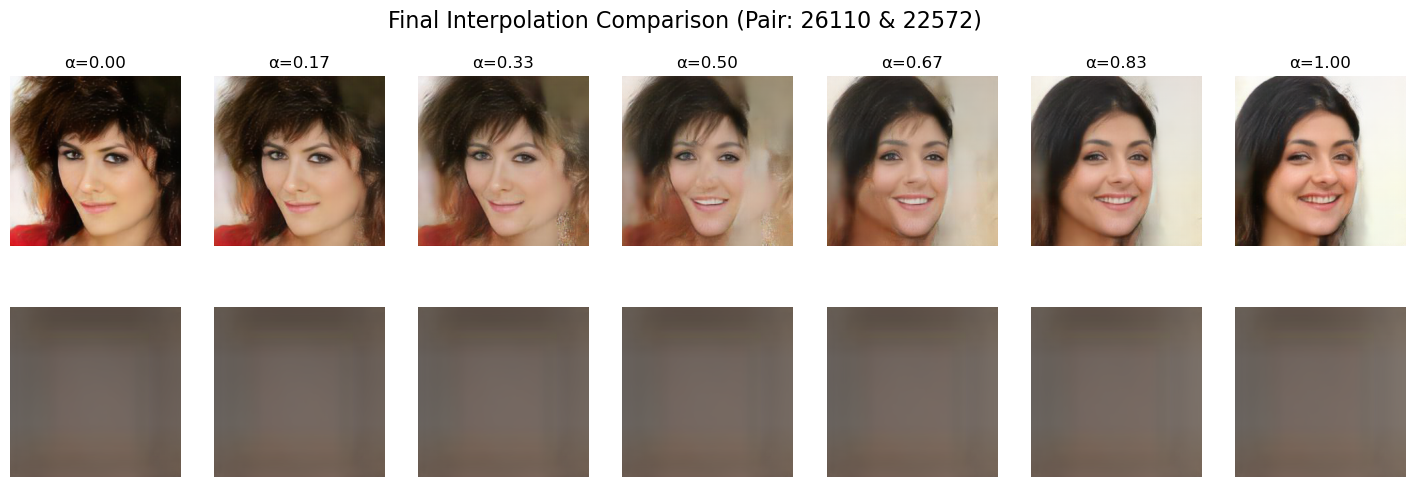


--- Test Pair #2 ---


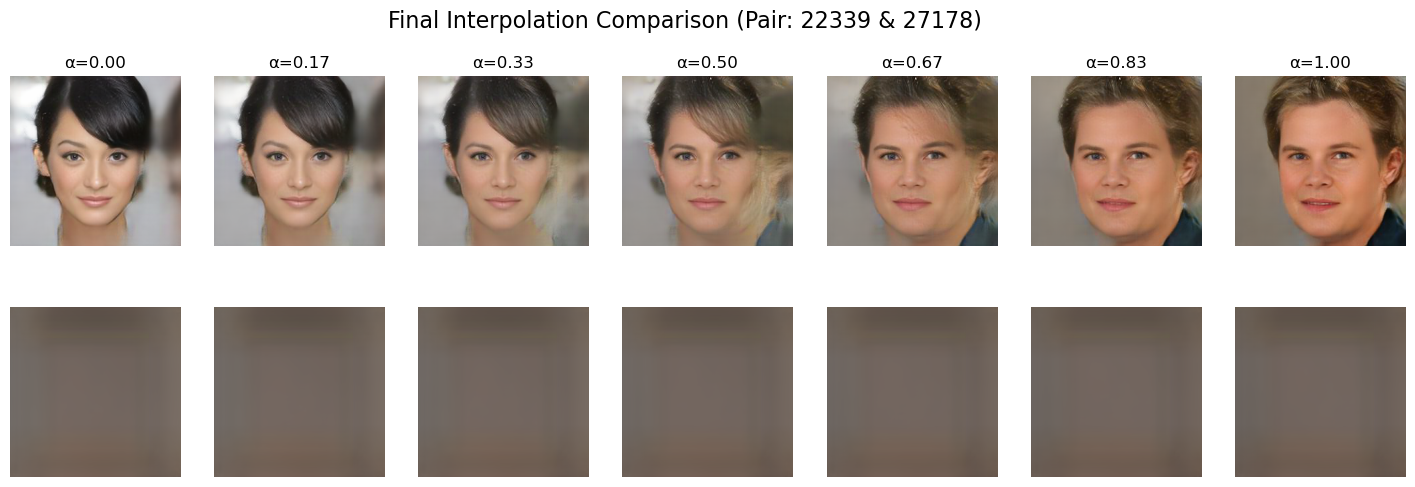


--- Test Pair #3 ---


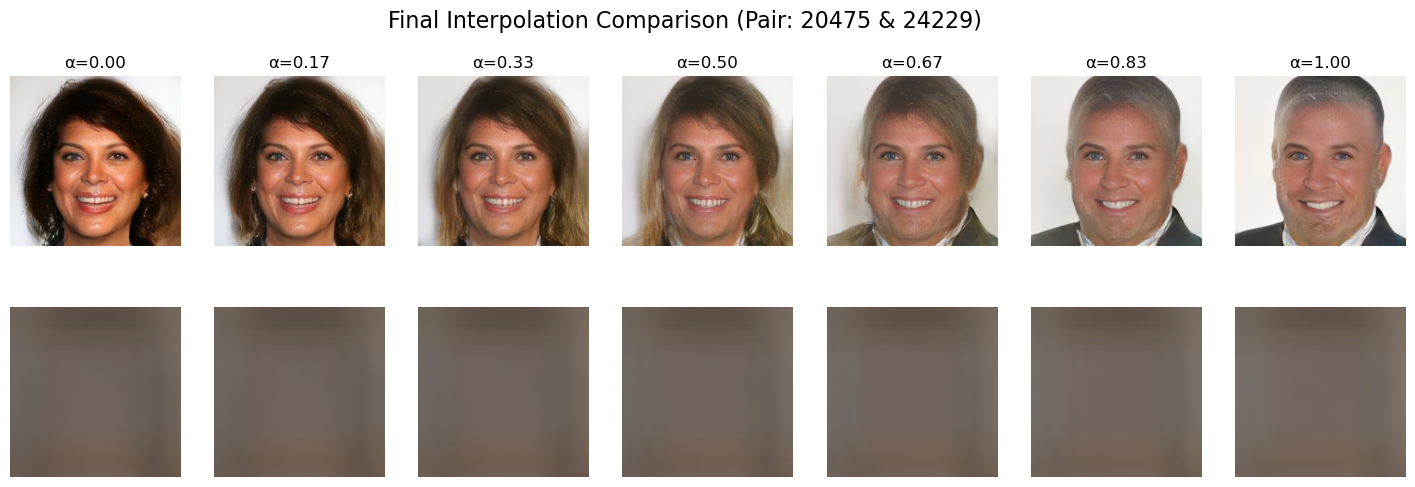


--- Test Pair #4 ---


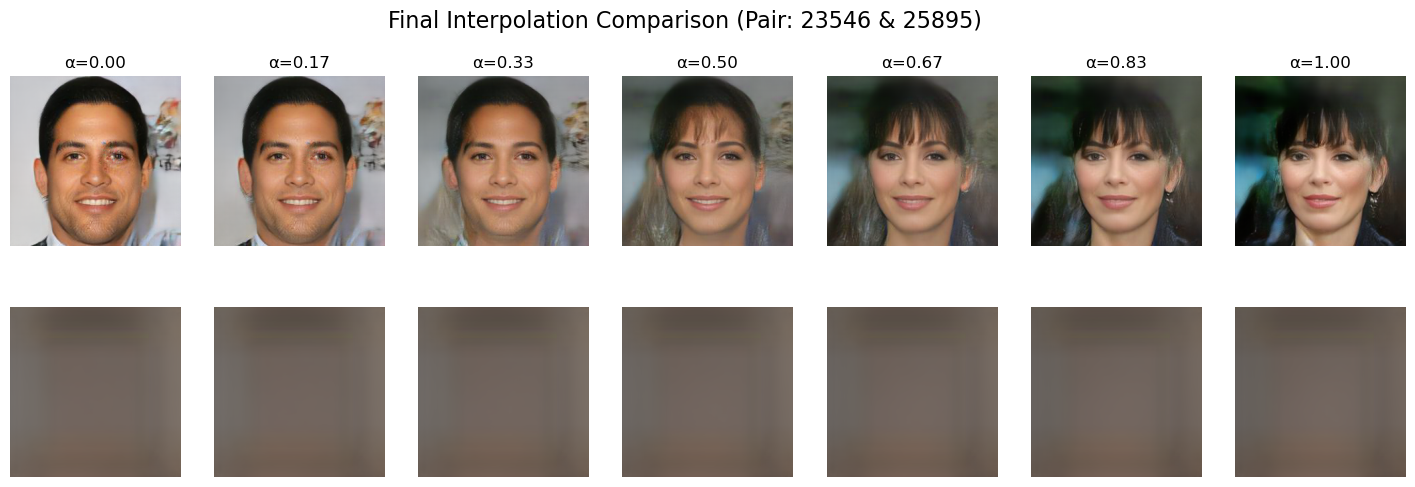


--- Test Pair #5 ---


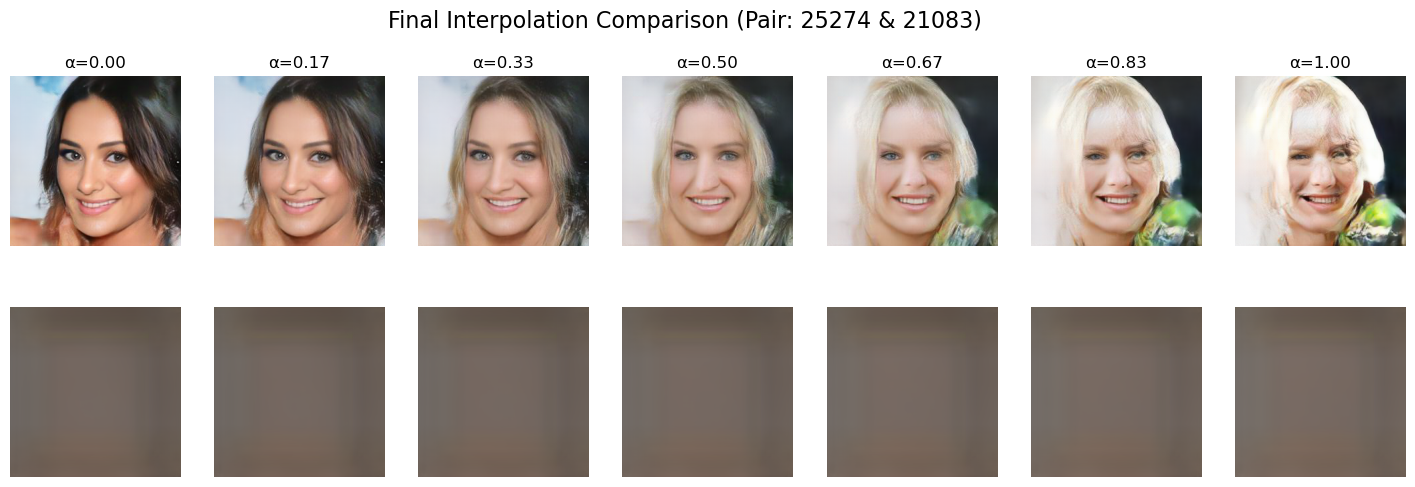

In [5]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import random

# --- 1. 모든 필요한 클래스 정의 ---
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels), nn.SiLU(), nn.Conv2d(out_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels))
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.silu = nn.SiLU()
    def forward(self, x): return self.silu(self.block(x) + self.shortcut(x))

class EncoderSuperDeep(nn.Module):
    def __init__(self, in_channels=3, base_channels=128, latent_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(in_channels, base_channels, 3, 1, 1), ResBlock(base_channels, base_channels), nn.Conv2d(base_channels, base_channels*2, 3, 2, 1), ResBlock(base_channels*2, base_channels*2), nn.Conv2d(base_channels*2, base_channels*4, 3, 2, 1), ResBlock(base_channels*4, base_channels*4), nn.Conv2d(base_channels*4, base_channels*8, 3, 2, 1), ResBlock(base_channels*8, base_channels*8), nn.Conv2d(base_channels*8, base_channels*16, 3, 2, 1), ResBlock(base_channels*16, base_channels*16), nn.Conv2d(base_channels*16, 2 * latent_channels, 3, 1, 1))
    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=1)
        return mu, log_var

class DecoderSuperDeep(nn.Module):
    def __init__(self, out_channels=3, base_channels=128, latent_channels=1):
        super().__init__()
        self.decoder = nn.Sequential(nn.Conv2d(latent_channels, base_channels*16, 3, 1, 1), ResBlock(base_channels*16, base_channels*16), nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*16, base_channels*8, 3, 1, 1), ResBlock(base_channels*8, base_channels*8), nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*8, base_channels*4, 3, 1, 1), ResBlock(base_channels*4, base_channels*4), nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*4, base_channels*2, 3, 1, 1), ResBlock(base_channels*2, base_channels*2), nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*2, base_channels, 3, 1, 1), ResBlock(base_channels, base_channels), nn.Conv2d(base_channels, out_channels, 3, 1, 1), nn.Tanh())
    def forward(self, z): return self.decoder(z)

class InterpolationNet(nn.Module):
    def __init__(self, latent_dim=256, hidden_dim=1024):
        super().__init__()
        input_dim = latent_dim * 2 + 1
        self.network = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2, inplace=True), nn.Linear(hidden_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2, inplace=True), nn.Linear(hidden_dim, hidden_dim // 2), nn.BatchNorm1d(hidden_dim // 2), nn.LeakyReLU(0.2, inplace=True), nn.Linear(hidden_dim // 2, latent_dim))
    def forward(self, z_a, z_b, alpha):
        net_input = torch.cat([z_a, z_b, alpha], dim=1)
        return self.network(net_input)

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, idx

def denormalize(tensor):
    return (tensor.clamp(-1, 1) * 0.5) + 0.5


def test_final_interpolation_network(num_tests=5):
    # --- 2. 경로 설정 및 모델 로드 ---
    DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    
    AE_CHECKPOINT_DIR = '/home/nas/data/YMG/superdeep_ae/checkpoints/'
    ENCODER_PATH = os.path.join(AE_CHECKPOINT_DIR, 'encoder_superdeep_best.pth')
    DECODER_PATH = os.path.join(AE_CHECKPOINT_DIR, 'decoder_superdeep_best.pth')
    DATA_DIR = '/home/nas/data/YMG/datas/celeba_hq_256/'
    
    # 방금 학습을 마친 보간 네트워크 체크포인트 경로
    INTERPOLATION_NET_DIR = '/home/nas/data/YMG/superdeep_ae/light_interpolation_network_attraction/'
    INTERPOLATION_NET_PATH = os.path.join(INTERPOLATION_NET_DIR, 'interpolation_net_best.pth')

    # 모든 모델 로드 (원본 VAE base_channels=128 기준)
    encoder = EncoderSuperDeep(base_channels=128).to(DEVICE); encoder.eval()
    decoder = DecoderSuperDeep(base_channels=128).to(DEVICE); decoder.eval()
    interpolation_net = InterpolationNet().to(DEVICE); interpolation_net.eval()

    encoder.load_state_dict(torch.load(ENCODER_PATH, map_location=DEVICE))
    decoder.load_state_dict(torch.load(DECODER_PATH, map_location=DEVICE))
    interpolation_net.load_state_dict(torch.load(INTERPOLATION_NET_PATH, map_location=DEVICE))
    print("모든 모델(원본 VAE, 최종 보간 네트워크)을 성공적으로 로드했습니다.")
    
    # 데이터셋 로드
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])
    dataset = CustomImageDataset(DATA_DIR, transform)
    
    # --- 3. 비교 테스트 수행 ---
    for i in range(num_tests):
        print(f"\n--- Test Pair #{i+1} ---")
        # 학습에 사용되지 않은 데이터(20000번 이후)에서 랜덤 샘플링
        start_idx, end_idx = random.sample(range(20000, 30000), 2)
        num_steps = 7
        alphas = torch.linspace(0, 1, num_steps)

        # 원본 이미지 및 잠재 벡터 준비
        img_a_orig, _ = dataset[start_idx]
        img_b_orig, _ = dataset[end_idx]
        with torch.no_grad():
            mu_a, _ = encoder(img_a_orig.unsqueeze(0).to(DEVICE))
            mu_b, _ = encoder(img_b_orig.unsqueeze(0).to(DEVICE))
        
        # 보간 수행 (선형 vs 네트워크)
        lerp_latents = torch.cat([(1 - alpha) * mu_a + alpha * mu_b for alpha in alphas], dim=0)
        
        network_latents = []
        with torch.no_grad():
            for alpha in alphas:
                mu_a_flat = mu_a.view(1, -1)
                mu_b_flat = mu_b.view(1, -1)
                alpha_tensor = torch.tensor([[alpha]], device=DEVICE)
                inter_latent_flat = interpolation_net(mu_a_flat, mu_b_flat, alpha_tensor)
                network_latents.append(inter_latent_flat.view(1, 1, 16, 16))
        network_latents = torch.cat(network_latents, dim=0)

        # 이미지 생성
        with torch.no_grad():
            lerp_images = decoder(lerp_latents).cpu()
            network_images = decoder(network_latents).cpu()

        # 시각화
        fig, axes = plt.subplots(2, num_steps, figsize=(18, 5.5))
        fig.suptitle(f"Final Interpolation Comparison (Pair: {start_idx} & {end_idx})", fontsize=16)
        axes[0, 0].set_ylabel("Linear (Lerp)", fontsize=12)
        axes[1, 0].set_ylabel("Trained Network ($I_\\theta$)", fontsize=12)

        for j in range(num_steps):
            axes[0, j].imshow(denormalize(lerp_images[j]).permute(1, 2, 0)); axes[0, j].axis('off')
            axes[1, j].imshow(denormalize(network_images[j]).permute(1, 2, 0)); axes[1, j].axis('off')
            axes[0, j].set_title(f"α={alphas[j]:.2f}")
        plt.show()

if __name__ == '__main__':
    test_final_interpolation_network()